# Prevendo a nota final dos alunos da Escola Todos Unidos

In [ ]:
pip install yellowbrick

In [80]:
#Importações de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Importação de funções das bibliotecas
from matplotlib.font_manager import FontProperties
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score
from yellowbrick.model_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

In [2]:
df_notas = pd.read_csv('student-mat.csv')
df_notas.shape

(395, 33)

In [ ]:
#Verificação de dados faltantes
def missing_values_table(df):
        mis_val = df.isnull().sum() # conta a quantidade de missing
        mis_val_percent = 100 * df.isnull().sum() / len(df) # calcula a porcentagem
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) # cria uma tabela
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valores faltantes', 1 : '% do total'}) # renomeia as colunas
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% do total', ascending=False).round(1) # ordena os valores
        print ("Você selecionou um dataframe que tem " + str(df.shape[1]) + " colunas.\n"      
            "E há " + str(mis_val_table_ren_columns.shape[0]) +
              " colunas com valores faltantes")
        return mis_val_table_ren_columns

In [ ]:
missing_df = missing_values_table(df_notas)
missing_df.tail()

## Preparação da planilha

### TRATANDO DADOS CATEGÓRICOS: Transformar variáveis categóricas em numéricas
Para análise comparativa das variáveis, precisamos que todas fiquem numéricas

In [3]:
#categorias com strings
categoricas = ['school',\
               'sex',\
              'address',\
              'famsize',\
               'Pstatus',\
               'Mjob',\
               'Fjob',\
               'reason',\
               'guardian',\
               'schoolsup',\
               'famsup',\
               'paid',\
               'activities',\
               'nursery',\
               'higher',\
               'internet',\
               'romantic',
                ]

In [4]:
# Escolher o melhor método (um ficará comentado)
le = LabelEncoder()
# apply le on categorical feature columns
df_notas[categoricas] = df_notas[categoricas].apply(lambda col: le.fit_transform(col))
df_notas[categoricas].head( )

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,0,0,1,0,0,0,4,0,1,1,0,0,0,1,1,0,0
1,0,0,1,0,1,0,2,0,0,0,1,0,0,0,1,1,0
2,0,0,1,1,1,0,2,2,1,1,0,1,0,1,1,1,0
3,0,0,1,0,1,1,3,1,1,0,1,1,1,1,1,1,1
4,0,0,1,0,1,2,2,1,0,0,1,1,0,1,1,0,0


In [ ]:
#oe = OrdinalEncoder()
#categorical = df_notas[categoricas]
#oe.fit(categorical)
#numerical = oe.transform(categorical)

#for n, feat in enumerate(categoricas):
#    df_notas[feat] = numerical[:, n]
#df_notas.head( )

In [5]:
# Configura a tabela
X = df_notas.drop('G3', axis=1)
y = df_notas['G3']

#Divide as variáveis em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Normalização dos dados
A normalização dos dados coloca-os na mesma ordem de grandeza

In [64]:
#Este processo PADRONIZA as variáveis
std = preprocessing.StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)
y_train_std = std.fit_transform(y_train.values.reshape(-1,1))
y_test_std = std.transform(y_test.values.reshape(-1,1))

#df_notas = pd.DataFrame(StandardScaler().fit_transform(X_train_std), columns=X_train.columns, index=X_train.index)
#X.head( )

In [13]:
df_notasTRAIN = pd.DataFrame(StandardScaler().fit_transform(X_train_std), columns=X_train.columns, index=X_train.index)

In [84]:
df_notasTEST = pd.DataFrame(StandardScaler().fit_transform(X_test_std), columns=X_test.columns, index=X_test.index)

In [14]:
df_notasTRAIN.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
17,-0.32249,-0.916515,-0.560008,0.504525,-0.644503,0.329293,0.244103,0.459335,-0.137555,-0.236555,...,-0.724474,1.215287,-0.249043,-1.016419,-0.557247,-1.013096,0.322877,-0.221442,-0.944757,-0.202857
165,-0.32249,1.091089,-0.560008,0.504525,-0.644503,0.329293,0.244103,-0.479750,0.670213,0.889122,...,-0.724474,0.050637,1.714836,-1.016419,-0.557247,-1.013096,-1.080495,1.159755,0.308863,0.066319
24,-0.32249,-0.916515,-1.336703,-1.982062,-0.644503,0.329293,-0.691625,1.398420,0.670213,-1.362233,...,-0.724474,0.050637,-0.249043,-1.016419,-0.557247,-1.013096,1.024563,-0.451641,-0.317947,-0.472032
126,-0.32249,-0.916515,-1.336703,0.504525,1.551582,-3.036811,0.244103,1.398420,-0.137555,-0.236555,...,1.380313,1.215287,-0.249043,-1.016419,-0.557247,-1.013096,-1.782181,-0.681841,-1.258162,-0.202857
346,-0.32249,1.091089,0.993381,-1.982062,-0.644503,0.329293,1.179830,0.459335,1.477980,0.889122,...,1.380313,1.215287,-0.249043,-1.016419,-0.557247,-0.247029,0.322877,0.354057,1.562483,1.143019


In [ ]:
#Este processo NORMALIZA as variáveis - ESCOLHER APENAS UM PROCESSO
#escala = Normalizer().fit(df_notas)
#df_notasN = escala.transform(df_notas)
#df_notas = pd.DataFrame(Normalizer().fit_transform(df_notasN), columns=df_notas.columns, index=df_notas.index)

### Construindo gráficos de demonstração de importância das variáveis

In [ ]:
#X = df_notas.drop('G3', axis=1)
#y = df_notas['G3']
#print(X.shape)
#print(y.shape)

## Dados preparados para escolha do tipo de algoritmo
O algoritmo escolhido após vários testes foi o ELastic Net

### Gráficos Yellowbrick

C:\python\anaconda\envs\ai-girls-ML\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


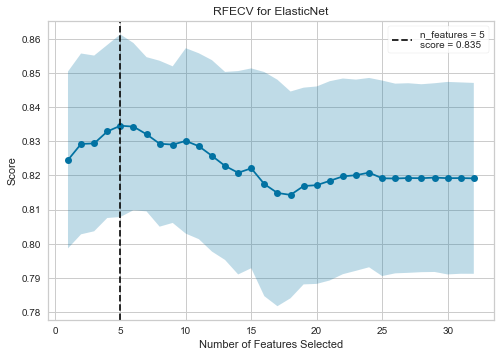

<AxesSubplot:title={'center':'RFECV for ElasticNet'}, xlabel='Number of Features Selected', ylabel='Score'>

In [65]:
#Gera um gráfico com a melhor quantidade de variáveis a ser considerada e quais são elas
visualizer = RFECV(ElasticNet(alpha=0.0001,l1_ratio=0.1), cv=5, scoring='r2')
visualizer.fit(X_train_std, y_train_std)
visualizer.show()

In [66]:
df_notasTRAIN.loc[:, df_notasTRAIN.columns != 'IN_TREINEIRO'].columns[visualizer.support_] #colunas que ele retornou como importante

Index(['schoolsup', 'famrel', 'absences', 'G1', 'G2'], dtype='object')

### Depois de aplicar o Yellowbrick

In [92]:
#Cria planilha nova APENAS COM as features que o Yellowbrick considerou IMPORTANTES (drop nas demais)
df_notas3 = df_notasTRAIN.loc[:, ['schoolsup', 'famrel', 'absences', 'G1', 'G2']]
df_notas3test = df_notasTEST.loc[:, ['schoolsup', 'famrel', 'absences', 'G1', 'G2']]

### Plot comparativo de variáveis indicadas no Yellowbrick + 3 escolhidas aleatoriamente

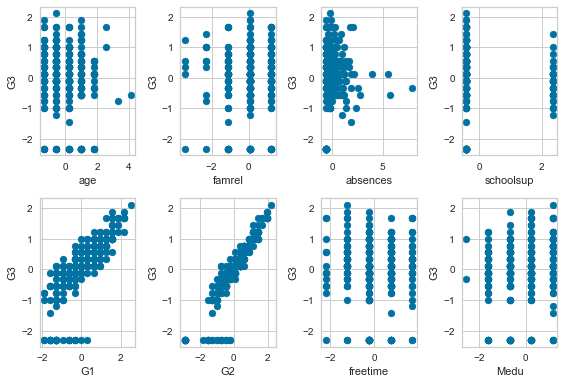

In [67]:
# Cria gráficos que demonstram as posições dos dados usando as variáveis indicadas no Yellowbrick, em uma matriz (2,4)
fig, ax = plt.subplots(2, 4)
ax[0,0].scatter(df_notasTRAIN.iloc[:,2],y_train_std);
ax[0,0].set_xlabel('age');
ax[0,0].set_ylabel('G3');

ax[0,1].scatter(df_notasTRAIN.iloc[:,23],y_train_std);
ax[0,1].set_xlabel('famrel');
ax[0,1].set_ylabel('G3');

ax[0,2].scatter(df_notasTRAIN.iloc[:,29],y_train_std);
ax[0,2].set_xlabel('absences');
ax[0,2].set_ylabel('G3');

ax[0,3].scatter(df_notasTRAIN.iloc[:,15],y_train_std);
ax[0,3].set_xlabel('schoolsup');
ax[0,3].set_ylabel('G3');

ax[1,0].scatter(df_notasTRAIN.iloc[:,30],y_train_std);
ax[1,0].set_xlabel('G1');
ax[1,0].set_ylabel('G3');

ax[1,1].scatter(df_notasTRAIN.iloc[:,31],y_train_std);
ax[1,1].set_xlabel('G2');
ax[1,1].set_ylabel('G3');

ax[1,2].scatter(df_notasTRAIN.iloc[:,24],y_train_std);
ax[1,2].set_xlabel('freetime');
ax[1,2].set_ylabel('G3');

ax[1,3].scatter(df_notasTRAIN.iloc[:,6],y_train_std);
ax[1,3].set_xlabel('Medu');
ax[1,3].set_ylabel('G3');

plt.tight_layout();

# Regressor ElasticNet
De acordo com https://medium.com/turing-talks/turing-talks-20-regressão-de-ridge-e-lasso-a0fc467b5629 esse método pode ser melhor para o tipo de problema sugerido

### Teste com planilha completa

In [68]:
#X = df_notas.drop('G3', axis=1)
#y = df_notas['G3']
#X = df_notas3
alphas = [0.0001,0.001, 0.01, 0.1, 0.5, 1]
l1s = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
score = []

In [69]:
#Teste com diferentes alphas e l1_ratio
for i in range(len(alphas)):
    for j in range(len(l1s)):
        teste_EN = ElasticNet(alpha=alphas[i],l1_ratio=l1s[j])
        teste_EN.fit(X_train_std, y_train_std)
        score = teste_EN.score(X_train_std, y_train_std)
        print("alpha = ",alphas[i]," l1_ratio = ",l1s[j]," Score = ",score)

alpha =  0.0001  l1_ratio =  0.1  Score =  0.860689567562058
alpha =  0.0001  l1_ratio =  0.2  Score =  0.8606895554869238
alpha =  0.0001  l1_ratio =  0.3  Score =  0.8606895345861875
alpha =  0.0001  l1_ratio =  0.4  Score =  0.8606895047983133
alpha =  0.0001  l1_ratio =  0.5  Score =  0.8606894663198892
alpha =  0.0001  l1_ratio =  0.6  Score =  0.8606894194239869
alpha =  0.0001  l1_ratio =  0.7  Score =  0.860689362610986
alpha =  0.0001  l1_ratio =  0.8  Score =  0.8606892989838193
alpha =  0.0001  l1_ratio =  0.9  Score =  0.8606892241950178
alpha =  0.001  l1_ratio =  0.1  Score =  0.8606876626920462
alpha =  0.001  l1_ratio =  0.2  Score =  0.8606864536631251
alpha =  0.001  l1_ratio =  0.3  Score =  0.8606843667146571
alpha =  0.001  l1_ratio =  0.4  Score =  0.860681353240844
alpha =  0.001  l1_ratio =  0.5  Score =  0.8606774118556821
alpha =  0.001  l1_ratio =  0.6  Score =  0.8606725411691329
alpha =  0.001  l1_ratio =  0.7  Score =  0.8606667397876224
alpha =  0.001  l1

### Aplicando o regressor

In [70]:
# Usando os dados da linha anterior, o melhor score
notas_completa = ElasticNet(alpha=0.0001,l1_ratio=0.1)
notas_completa.fit(X_train_std, y_train_std)

ElasticNet(alpha=0.0001, l1_ratio=0.1)

In [71]:
y_pred = notas_completa.predict(X_test_std)

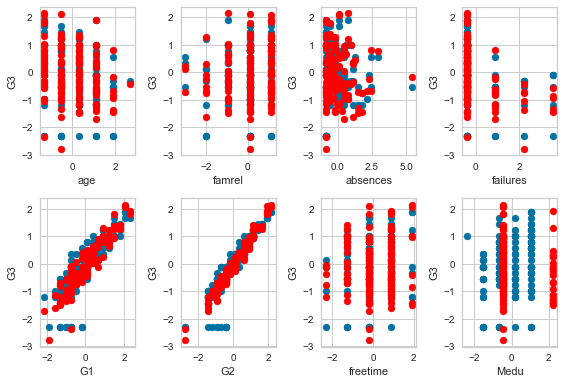

In [72]:
# Cria gráficos que demonstram as posições dos dados usando as variáveis indicadas no Yellowbrick, em uma matriz (3,3)
fig, ax = plt.subplots(2, 4)
ax[0,0].scatter(df_notasTEST.iloc[:,2],y_test_std);
ax[0,0].scatter(df_notasTEST.iloc[:,2],y_pred,color='red');
ax[0,0].set_xlabel('age');
ax[0,0].set_ylabel('G3');

ax[0,1].scatter(df_notasTEST.iloc[:,23],y_test_std);
ax[0,1].scatter(df_notasTEST.iloc[:,23],y_pred,color='red');
ax[0,1].set_xlabel('famrel');
ax[0,1].set_ylabel('G3');

ax[0,2].scatter(df_notasTEST.iloc[:,29],y_test_std);
ax[0,2].scatter(df_notasTEST.iloc[:,29],y_pred,color='red');
ax[0,2].set_xlabel('absences');
ax[0,2].set_ylabel('G3');

ax[0,3].scatter(df_notasTEST.iloc[:,14],y_test_std);
ax[0,3].scatter(df_notasTEST.iloc[:,14],y_pred,color='red');
ax[0,3].set_xlabel('failures');
ax[0,3].set_ylabel('G3');

ax[1,0].scatter(df_notasTEST.iloc[:,30],y_test_std);
ax[1,0].scatter(df_notasTEST.iloc[:,30],y_pred,color='red');
ax[1,0].set_xlabel('G1');
ax[1,0].set_ylabel('G3');

ax[1,1].scatter(df_notasTEST.iloc[:,31],y_test_std);
ax[1,1].scatter(df_notasTEST.iloc[:,31],y_pred,color='red');
ax[1,1].set_xlabel('G2');
ax[1,1].set_ylabel('G3');

ax[1,2].scatter(df_notasTEST.iloc[:,24],y_test_std);
ax[1,2].scatter(df_notasTEST.iloc[:,24],y_pred,color='red');
ax[1,2].set_xlabel('freetime');
ax[1,2].set_ylabel('G3');

ax[1,3].scatter(df_notasTEST.iloc[:,6],y_test_std);
ax[1,3].scatter(df_notasTEST.iloc[:,0],y_pred,color='red');
ax[1,3].set_xlabel('Medu');
ax[1,3].set_ylabel('G3');

plt.tight_layout();

### Métricas com planilha completa

In [73]:
#avaliação da qualidade do modelo
score = notas_completa.score(X_test_std, y_test_std)
print('Score:', score)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_std, y_pred)) #próx de 0, melhor
print('Mean Squared Error:', metrics.mean_squared_error(y_test_std, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_std, y_pred))) #medida de dispersão

Score: 0.794777899003827
Mean Absolute Error: 0.30925496208908265
Mean Squared Error: 0.22027376103313767
Root Mean Squared Error: 0.4693333154945829


## Teste apenas com as colunas marcadas como importantes no Yellowbrick

In [93]:
#X = df_notas.drop('G3', axis=1)
#y = df_notas['G3']
#X = df_notas3

#Divide as variáveis em treino e teste
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas_P = [0.0001,0.001, 0.01, 0.1, 0.5, 1]
l1s_P = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
score = []

In [94]:
#Teste com diferentes alphas e l1_ratio
for i in range(len(alphas)):
    for j in range(len(l1s)):
        teste_EN = ElasticNet(alpha=alphas[i],l1_ratio=l1s[j])
        teste_EN.fit(df_notas3, y_train_std)
        score = teste_EN.score(df_notas3, y_train_std)
        print("alpha = ",alphas[i]," l1_ratio = ",l1s[j]," Score = ",score)

alpha =  0.0001  l1_ratio =  0.1  Score =  0.8443109087709009
alpha =  0.0001  l1_ratio =  0.2  Score =  0.8443109040337164
alpha =  0.0001  l1_ratio =  0.3  Score =  0.8443108995393145
alpha =  0.0001  l1_ratio =  0.4  Score =  0.8443109005139653
alpha =  0.0001  l1_ratio =  0.5  Score =  0.8443109004926292
alpha =  0.0001  l1_ratio =  0.6  Score =  0.8443108994751318
alpha =  0.0001  l1_ratio =  0.7  Score =  0.8443108974612984
alpha =  0.0001  l1_ratio =  0.8  Score =  0.8443108944509545
alpha =  0.0001  l1_ratio =  0.9  Score =  0.8443108904439254
alpha =  0.001  l1_ratio =  0.1  Score =  0.8443094871830916
alpha =  0.001  l1_ratio =  0.2  Score =  0.8443095376340328
alpha =  0.001  l1_ratio =  0.3  Score =  0.8443094893173568
alpha =  0.001  l1_ratio =  0.4  Score =  0.8443093420614278
alpha =  0.001  l1_ratio =  0.5  Score =  0.8443090956941114
alpha =  0.001  l1_ratio =  0.6  Score =  0.8443087500427732
alpha =  0.001  l1_ratio =  0.7  Score =  0.8443083049342768
alpha =  0.001 

In [95]:
# Usando os dados da linha anterior, o melhor score
notas_parcial = ElasticNet(alpha=0.0001,l1_ratio=0.1)
notas_parcial.fit(df_notas3, y_train_std)

ElasticNet(alpha=0.0001, l1_ratio=0.1)

In [96]:
y_pred = notas_parcial.predict(df_notas3test)

### Plot dos gráficos comparativos

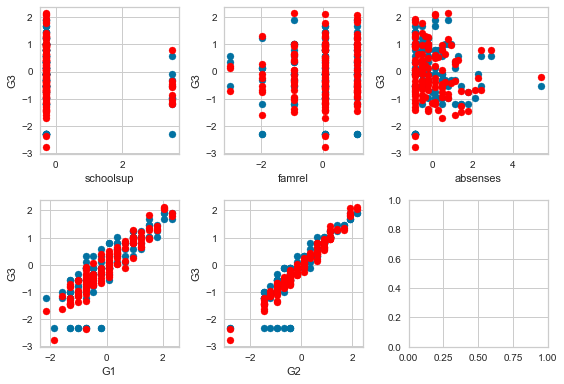

In [76]:
# Cria gráficos que demonstram as posições dos dados usando as variáveis indicadas no Yellowbrick, em uma matriz (2,3)
# acrescido do plot da predição
fig, ax = plt.subplots(2, 3)
ax[0,0].scatter(df_notas3test.iloc[:,0],y_test_std);
ax[0,0].scatter(df_notas3test.iloc[:,0],y_pred,color='red');
ax[0,0].set_xlabel('schoolsup');
ax[0,0].set_ylabel('G3');

ax[0,1].scatter(df_notas3test.iloc[:,1],y_test_std);
ax[0,1].scatter(df_notas3test.iloc[:,1],y_pred,color='red');
ax[0,1].set_xlabel('famrel');
ax[0,1].set_ylabel('G3');

ax[0,2].scatter(df_notas3test.iloc[:,2],y_test_std);
ax[0,2].scatter(df_notas3test.iloc[:,2],y_pred,color='red');
ax[0,2].set_xlabel('absenses');
ax[0,2].set_ylabel('G3');

ax[1,0].scatter(df_notas3test.iloc[:,3],y_test_std);
ax[1,0].scatter(df_notas3test.iloc[:,3],y_pred,color='red');
ax[1,0].set_xlabel('G1');
ax[1,0].set_ylabel('G3');

ax[1,1].scatter(df_notas3test.iloc[:,4],y_test_std);
ax[1,1].scatter(df_notas3test.iloc[:,4],y_pred,color='red');
ax[1,1].set_xlabel('G2');
ax[1,1].set_ylabel('G3');

plt.tight_layout();

In [61]:
df_notas3test.head()

,schoolsup,famrel,absences,G1,G2
78,3.496029,0.086175,-0.530346,-0.745220,-0.680979
371,-0.286039,0.086175,-0.365133,0.933289,0.357951
248,-0.286039,0.086175,0.460929,-2.143978,-1.460177
55,-0.286039,1.111656,0.460929,-0.745220,-0.421247
390,-0.286039,1.111656,0.956566,-0.465469,-0.421247


#### Métricas do Modelo só com as colunas indicadas no Yellowbrick como importantes 

In [97]:
#avaliação da qualidade do modelo
score = notas_parcial.score(df_notas3test, y_test_std)
print('Score:', score)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_std, y_pred)) #próx de 0, melhor
print('Mean Squared Error:', metrics.mean_squared_error(y_test_std, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_std, y_pred))) #medida de dispersão

Score: 0.8027525371495177
Mean Absolute Error: 0.27586846100386886
Mean Squared Error: 0.21171423684591412
Root Mean Squared Error: 0.4601241537301798


## Teste para verificar as variáveis que influenciam em G2

In [ ]:
df_notas2 = df_notas.drop('G3', axis=1)
#y = df_notas['G3']
print(X.shape)
print(y.shape)

In [ ]:
X = df_notas2.drop('G2', axis=1)
y = df_notas['G2']

In [ ]:
X.columns

In [ ]:
visualizer = RFECV(ElasticNet(alpha=0.0001,l1_ratio=0.1), cv=15, scoring='r2')
visualizer.fit(X, y)
visualizer.show()

In [ ]:
#Divide as variáveis em treino e teste
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = [0.0001,0.001, 0.01, 0.1, 0.5, 1]
l1s = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
score = []

In [ ]:
#Teste com diferentes alphas e l1_ratio
for i in range(len(alphas)):
    for j in range(len(l1s)):
        teste_EN = ElasticNet(alpha=alphas[i],l1_ratio=l1s[j])
        teste_EN.fit(X_train, y_train)
        score = teste_EN.score(X_train, y_train)
        print("alpha = ",alphas[i]," l1_ratio = ",l1s[j]," Score = ",score)

In [ ]:
X.loc[:, X.columns != 'IN_TREINEIRO'].columns[visualizer.support_] #colunas

## Testando o que influencia G1

In [ ]:
df_notas4 = X

In [ ]:
X = df_notas4.drop('G1', axis=1)
y = df_notas['G1']

In [ ]:
visualizer = RFECV(ElasticNet(alpha=0.0001,l1_ratio=0.1), cv=9, scoring='r2')
visualizer.fit(X, y)
visualizer.show()

In [ ]:
X.loc[:, X.columns != 'IN_TREINEIRO'].columns[visualizer.support_] #colunas

In [ ]:
#Divide as variáveis em treino e teste
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = [0.0001,0.001, 0.01, 0.1, 0.5, 1]
l1s = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
score = []

In [ ]:
#Teste com diferentes alphas e l1_ratio
for i in range(len(alphas)):
    for j in range(len(l1s)):
        teste_EN = ElasticNet(alpha=alphas[i],l1_ratio=l1s[j])
        teste_EN.fit(X_train, y_train)
        score = teste_EN.score(X_train, y_train)
        print("alpha = ",alphas[i]," l1_ratio = ",l1s[j]," Score = ",score)

## Teste sem G1 e G2, mas com target no G3 - GRUPO C

In [ ]:
df_notas4.columns

In [ ]:
X = df_notas4.drop('G1', axis=1)
y = df_notas['G3']

In [ ]:
visualizer = RFECV(ElasticNet(alpha=0.0001,l1_ratio=0.1), cv=10, scoring='r2')
visualizer.fit(X, y)
visualizer.show()

In [ ]:
X.loc[:, X.columns != 'IN_TREINEIRO'].columns[visualizer.support_] #colunas

In [ ]:
alphas = [0.0001,0.001, 0.01, 0.1, 0.5, 1]
l1s = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
score = []

In [ ]:
#Teste com diferentes alphas e l1_ratio
for i in range(len(alphas)):
    for j in range(len(l1s)):
        teste_C = ElasticNet(alpha=alphas[i],l1_ratio=l1s[j])
        teste_C.fit(X_train, y_train)
        score = teste_C.score(X_train, y_train)
        print("alpha = ",alphas[i]," l1_ratio = ",l1s[j]," Score = ",score)

# Teste com RandomForest

C:\python\anaconda\envs\ai-girls-ML\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


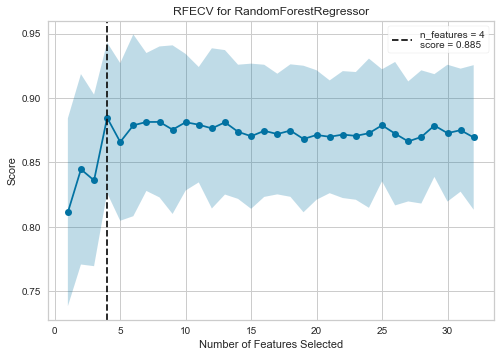

<AxesSubplot:title={'center':'RFECV for RandomForestRegressor'}, xlabel='Number of Features Selected', ylabel='Score'>

In [81]:
visualizer = RFECV(RandomForestRegressor(), cv=10, scoring='r2')
visualizer.fit(X_train_std, y_train_std)
visualizer.show()

In [82]:
df_notasTRAIN.loc[:, df_notasTRAIN.columns != 'IN_TREINEIRO'].columns[visualizer.support_] #colunas que ele retornou como importante

Index(['age', 'reason', 'absences', 'G2'], dtype='object')

### Aplicação do RFR somente com as features escolhidas

In [87]:
#Cria planilha nova APENAS COM as features que o Yellowbrick considerou IMPORTANTES (drop nas demais)
df_notasRFR = df_notasTRAIN.loc[:, ['age', 'reason', 'absences', 'G2']]
df_notasRFRtest = df_notasTEST.loc[:, ['age', 'reason', 'absences', 'G2']]

In [88]:
#Aplicação do RFR
# Fit regression model
RFR = RandomForestRegressor(max_depth=5)
RFR.fit(df_notasRFR, y_train_std)

# Predict
y_pred = RFR.predict(df_notasRFRtest)

<ipython-input-88-67cad7f86929>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(df_notasRFR, y_train_std)


In [91]:
#avaliação da qualidade do modelo RFR apenas nas colunas indicadas no yellowbrick
score = RFR.score(df_notasRFR_test, y_test_std)
print('Score:', score)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_std, y_pred)) #próx de 0, melhor
print('Mean Squared Error:', metrics.mean_squared_error(y_test_std, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_std, y_pred))) #medida de dispersão

Score: 0.8680632538868873
Mean Absolute Error: 0.21878464010161056
Mean Squared Error: 0.14161341855354806
Root Mean Squared Error: 0.3763155837240175


### Teste com Random Forest Regressor com a tabela toda

In [99]:
#Aplicação do RFR
# Fit regression model
RFR_completa = RandomForestRegressor(max_depth=5)
RFR_completa.fit(X_train_std, y_train_std)

# Predict
y_pred = RFR_completa.predict(X_test_std)

<ipython-input-99-96d76aba9af0>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR_completa.fit(X_train_std, y_train_std)


In [100]:
#avaliação da qualidade do modelo RFR apenas nas colunas indicadas no yellowbrick
score = RFR_completa.score(X_test_std, y_test_std)
print('Score:', score)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_std, y_pred)) #próx de 0, melhor
print('Mean Squared Error:', metrics.mean_squared_error(y_test_std, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_std, y_pred))) #medida de dispersão

Score: 0.8670729526437877
Mean Absolute Error: 0.227444596028378
Mean Squared Error: 0.142676351728457
Root Mean Squared Error: 0.37772523311059986


# Conclusões?

Comparação dos testes:

##### Teste RFR apenas com colunas Yellowbrick
Score: 0.8680632538868873 \
Mean Absolute Error: 0.21878464010161056 \
Mean Squared Error: 0.14161341855354806 \
Root Mean Squared Error: 0.3763155837240175 \

##### Teste RFR com planilha completa
Score: 0.8670729526437877 \
Mean Absolute Error: 0.227444596028378 \
Mean Squared Error: 0.142676351728457 \
Root Mean Squared Error: 0.37772523311059986 \

##### Teste Elastic Net apenas com colunas Yellowbrick
Score: 0.8027525371495177 \
Mean Absolute Error: 0.27586846100386886 \
Mean Squared Error: 0.21171423684591412 \
Root Mean Squared Error: 0.4601241537301798 \

##### Teste Elastic Net com planilha completa
Score: 0.794777899003827 \
Mean Absolute Error: 0.30925496208908265 \
Mean Squared Error: 0.22027376103313767 \
Root Mean Squared Error: 0.4693333154945829 \